# **This notebook create systems for molecular dynamics**

This notebook uses the methods detailed in the first notebook **"1_Generating_models_of_complex_fluids"** and takes the generated models one step further 
and produces usable outputs for molecular dynamics.

This notebook will cover a few things:

- Recap of generating representative models (the models are also required for the further functions used)
- Parameterization of molecules using AmberTools and the GAFF forcefield
- Generation of starting structures of complex mixtures using packmol
- Generation of **Amber** files (i.e. parameters, topologies and coordinates)

# **1. Import the required python modules.**

For a detailed explanation of these python modules, please refer to the first notebook or the documentation - the first few sections of this notebook will 
forego detailed explanations as these are covered in the first notebook.

In [1]:
# Import python modules
from modules.sw_directories import *
from modules.sw_orca import *
from modules.sw_complex_fluid_models import *
import os as os

# **2. Initialise the filepath manager and generate datafilepath.**

The datafile loaded will be the same one utilised in the first notebook. Any of the other datafiles provided in the **GC-data** directory will also work here and
contain the raw data presented in the associated publication.

In [2]:
# call 'BioOilDirs'
manager = BioOilDirs(os.getcwd())

# data file name
data_filename = "pb_cp.csv"

# data folder path
data_folder = manager.bio_oil_GC_data

# create filepath to data file
data_filepath = os.path.join(data_folder, data_filename) 

# **3. Generate moelcule objects and representative models.**

As in the first notebook, the complete fraction of the bio-oil will be covered here.

As seen before the four representative models: **FT, PT, AG** and **SG** will be generated, alongside the benchmark **ALL** model.

In [3]:
# Extract the csv data into list
molecules = csv_to_orca_class(data_filepath)

In [4]:
# Generate FT model - with a useful name
pb_cp_FT_model = complex_fluid_models.fixed_threshold_model(model_name="pb_cp", orca_molecules=molecules, selection_threshold=5)

# Generate PT model - with a useful name
pb_cp_PT_model = complex_fluid_models.proportional_threshold_model(model_name="pb_cp", orca_molecules=molecules)

# Generate AG model - with a useful name
pb_cp_AG_model = complex_fluid_models.abundancy_grouped_model(model_name="pb_cp", orca_molecules=molecules)

# Generate SG model - with a useful name
pb_cp_SG_model = complex_fluid_models.scored_grouped_model(model_name="pb_cp", orca_molecules=molecules)

# Generate SG model - with a useful name
pb_cp_ALL_model = complex_fluid_models.all_model(model_name="pb_cp", orca_molecules=molecules)

# **4. Generating parameters for each molecule in the model**

We may have jumped the gun slightly with already generating the representative models (this step could have been carried out first) but this is the first new section of the notebook.

This step uses AmberTools to generate parameters for each molecule within the fraction we are creating models of. This will allow for further molecular dynamics simulations.

The first stage is to load the builder module which originates from **sw_build_systems** module.

***Note:** there are many functions within the **sw_build_systems** module, those that a required to be used by the user are the only ones that will be explained*

The first stage is load the new modules we need and create a **builder** object.

Molecules will not be parameterized if they have already been parametrized!

In [5]:
from modules.sw_build_systems import *
from modules.sw_basic_functions import clean_mol_name, remove_conect_master_lines 

builder = BuildAmberSystems(manager)

Now we can use a function that will loop through the list of molecules and parameterize them. The list of molecules and the builder object will need to be
passed to the **parameterize_molecule_list** function.

In [22]:
# Package this up before the final run
def parameterize_molecule_list(manager, builder, molecules):
    for moleule in molecules:
        name, smiles = moleule.name, moleule.smiles
        if builder.is_mol_parametrized(name) == False:
            builder.SmilesToPDB_GenResCode(smiles, name)
            pdb = manager.load_pdb_filepath(name)
           # remove_conect_master_lines(pdb)
            builder.parameterize_mol(name)
           # remove_conect_master_lines(pdb)          

In [23]:
parameterize_molecule_list(manager, builder, molecules)

Output: 
Welcome to antechamber 22.0: molecular input file processor.

Info: acdoctor mode is on: check and diagnose problems in the input file.
Info: The atom type is set to gaff; the options available to the -at flag are
      gaff, gaff2, amber, bcc, and sybyl.

-- Check Format for pdb File --
   Status: pass
Info: Determining atomic numbers from atomic symbols which are case sensitive.
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Running: /home/dan/miniconda3/envs/AmberTools23/bin/bondtype -j full -i ANTECHAMBER_BOND_TYPE.AC0 -o ANTECHAMBER_BOND_TYPE.AC -f ac

Running: /home/dan/miniconda3/envs/AmberTools23/bin/atomtype -i ANTECHAMBER_AC.AC0 -o ANTECHAMBER_AC.AC -p gaff
Info: Total number of electrons: 168; net ch

The parameterized molecules will be located in the **~/pdb_files/molecules** directory. An example of the location and files generated for 
one parameterized molecule is shown below.

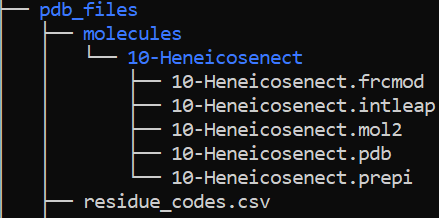

The contents of this directory are important for generating parameters of the entire system and packing the intial starting structure but to use this package it is 
not required what is in the contents of each file.

You will notice another file **residue_codes.csv** is also present. This file contains the name and smiles of each parameterized molecule along with a unique assigned residue code.
This assignment of a unique residue code helps with loading parameters for specfically molecules by parsing final pdb files.

In [18]:
for molecule in molecules:
    if molecule.name == "Apocynin":
        print(molecule.smiles)

CC(=O)C1=CC(=C(C=C1)O)OC


In [17]:
builder.SmilesToPDB_GenResCode("CC=OC1=CC=CC=C1OOC", "Apocynin")

'/home/dan/polymersimulator/bio_oil_package/pdb_files/Apocynin.pdb'

# **5. Generate starting structre of model using packmol**

Now all of the molecule are parameterized, lets run the command that generates a packmol cube for a system. Here only the example for the **FT** and **PT** models is shown.
The function works by generating a packmol input file and launching packmol to generate the desired structure. 
However, the methodology is the same for all models.

**WARNING**: Creating a packmol cube of the **ALL** model will take a long time and in many cases may not run at all - so proceed with caution. 
(*the whole point of the package is to circumvent creating these humoungous models that are rather impratical to run simulations of*)

In [ ]:
complex_fluid_model_builder.generate_packmol_bio_oil_cube(manager=manager, model=pb_cp_FT_model, tolerance=None, filetype=None)

The produced model in this case is super small (it only contains 11 molecules) but look like this:

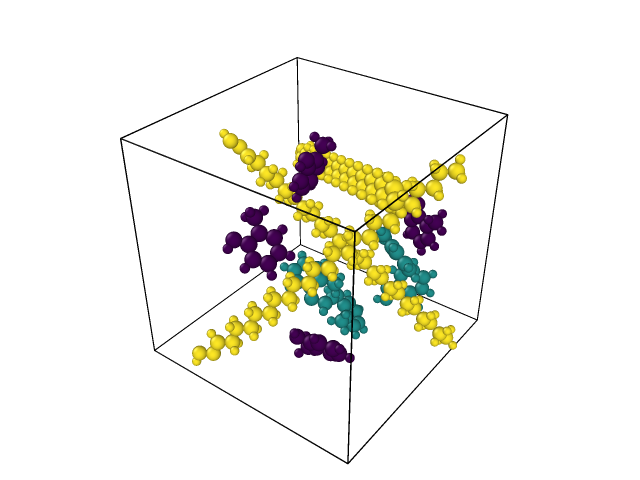

Lets create the starting structure of the **PT** model as this system contains many more molecules, it is worth ntoing systems with more molecules typically take longer to generate!

In [ ]:
complex_fluid_model_builder.generate_packmol_bio_oil_cube(manager, pb_cp_PT_model, tolerance=None, filetype=None)

In [ ]:
pb_cp_PT_model.min_mols_for_sim

The **PT** model contains 1894 moelcules and the starting structure looks like this:

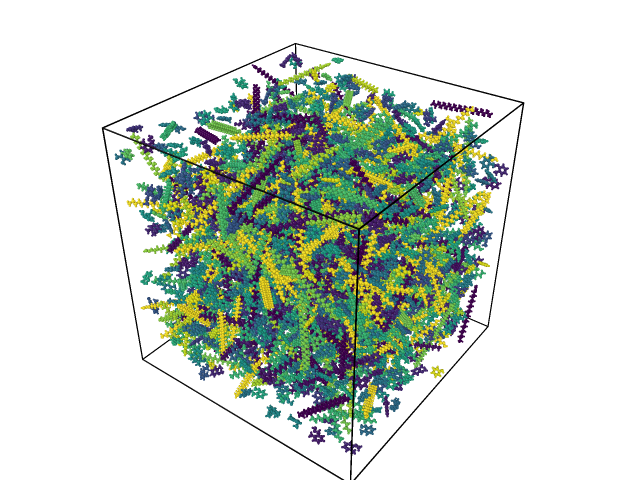

This looks more like it! This is a generated structure of the representative **PT** model for the complete fraction of pine-bark derived bio-oil!

It is worth noting where these files are saved:

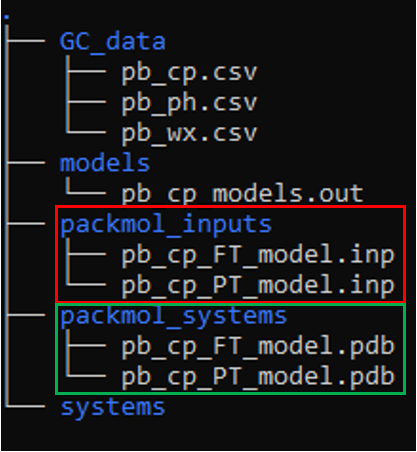

- <span style="color:#FF0000">Red</span>: The directory that contains input files for packmol.
- <span style="color:#00B050">Green</span>: The directory that contains output files from packmol.

### Changing volume of the model or number of molecules in the model ###

The command to generate the packmol cube has a couple of other arguments not shown above. This changes either the **volume** or **number_of_molecules** in a system by a specificed factor.
For example the **FT** model contains very few molecules and this is not suitable for an MD simulation - so the idea is we scale the number of molecules within a system by a given factor
whilst keeping the ratio of each molecule within the system the name.

An example of this is shown below where the number of molecules is multiplied by 5. The name of the file has changed to reflect the scaling of the atoms with a **mol_x5** extension.

***Note:** Any molecule scalars must be given as whole numbers to retain the stoichometry of the system and the programme will exit if anything else is provided*

In [5]:
complex_fluid_model_builder.generate_packmol_bio_oil_cube(manager=manager, model=pb_cp_FT_model, tolerance=None, filetype=None, molecule_scalar=5, volume_scalar=None)

/home/dan/packmol-20.14.4-docs1/packmol-20.14.4-docs1/packmol < /home/dan/polymersimulator/bio_oil_package/bio_oil/packmol_inputs/pb_cp_FT_model_mol_x5.inp
Output: 
################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.14.4 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Types of coordinate files specified: pdb
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /home/dan/polymersimulator/bio_oil_package/bio_oil/packmol_systems/pb_cp_FT_model_mol_x5.pdb
  Reading coordinate file: /home/dan/polymersimulator/bio_oil_package/p

()

The system generated now has the same stoichiometry as the initial **FT** model but with 5 times the amount of each initial molecule:

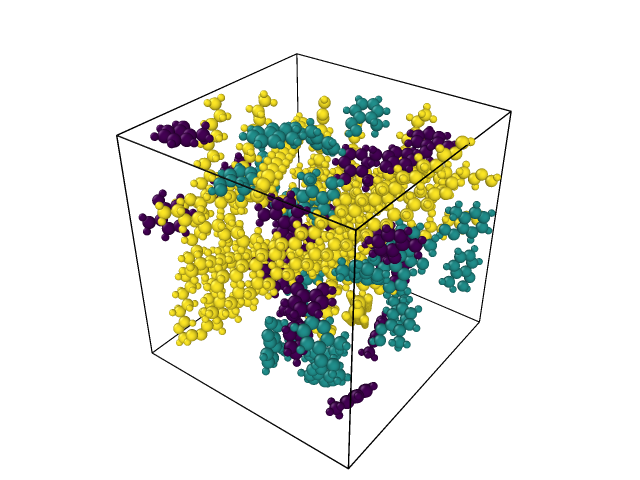

The files generated for this system (with the x5 molecule scalar) are different but are found in the same place and are appropriately named.

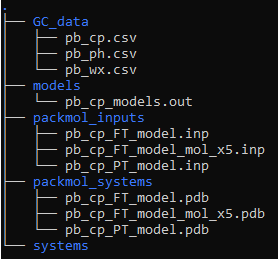

The volume scalar will not be covered here, but exists if there is a struggle to get pakcmol to run (see error **STOP 173** just below). By increasing the volume of the overall system, it becomes easier to pack all
of the molecules (It is recommended to start from **volume_scalar=2** in these cases and increase if difficulties still arise).

# **5.1 Packmol errors**

It is worth noting some common packmol errors I have encountered during testing so you can address the same errors if found (although hopefully they are fixed!).

The first error is **STOP 171** and a screenshot of what this look like in the notebook is found below:

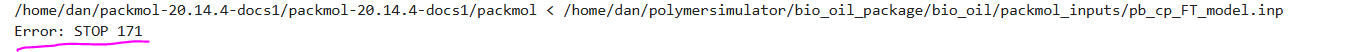

This error looks more like this in it totality:

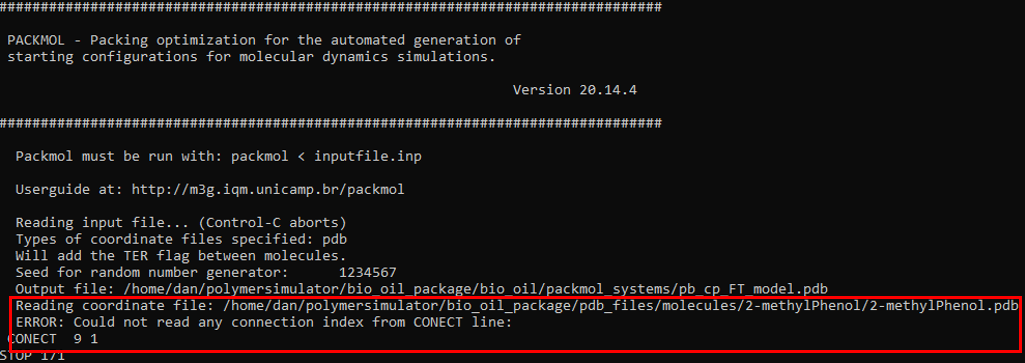

This error means the pdb files have not been prepared correctly and cannot be read by packmol - an edit has been made to the preceding code so hopefully you do not encounter this.

More specfically the pdb files that contain the lines **CONECT** cannot be parsed by packmol and a consideration has been taken to remove these from the pdb files in preparation.

The second error is **STOP 173** and a screenshot of what this looks like in the notebook is found below:

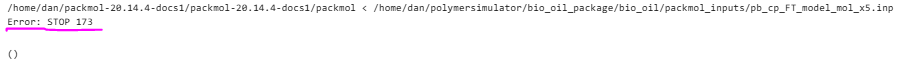

This error looks more like this in it totality:

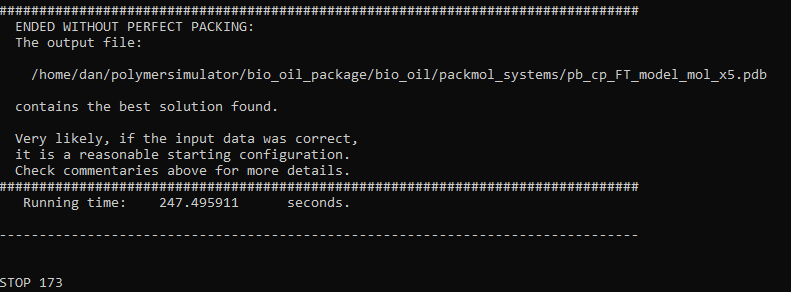

This error means a solution to perfect packing was not found and the volume scalar should be increased! There are two main reasons for this:

- (likely) The box is too small for the molecules given to it.
- (rare) in cases where the system is super big, long chains may be larger than the box length and difficult to pack diagonally.

# **6. Generate amber parameters of a model**

Carrying on with the 2 examples above (**FT** and **PT** models of the complete charecterisation on pine-bark derived bio-oil), the next step is to generate
parameters, topologies and coordinates for simulation.

A model has also been generated for the **FT** model with a 5x scaling value on the number of molecules. It is advised to try and generate the parameters for this system yourself after 
the following examples.

The first thing to do is find any available packmol systems that have been generated.

In [6]:
# What files available
avail_files = manager.bio_oil_pckml_systems_avail()

pb_cp_FT_model_mol_x5.pdb
pb_cp_FT_model.pdb
pb_cp_PT_model.pdb


When the above command is run, if a variable is assigned a list it outputed that contains the filepaths to these systems. 
Lets loop through this list:

In [7]:
# Print packmol system filepaths
for file in avail_files:
    print(file)

/home/dan/polymersimulator/bio_oil_package/bio_oil/packmol_systems/pb_cp_FT_model_mol_x5.pdb
/home/dan/polymersimulator/bio_oil_package/bio_oil/packmol_systems/pb_cp_FT_model.pdb
/home/dan/polymersimulator/bio_oil_package/bio_oil/packmol_systems/pb_cp_PT_model.pdb


Select the **FT** model by assigning it a variable.

In [8]:
# Select system to generate amber params for
system_to_gen_params = avail_files[1]
print(system_to_gen_params)

/home/dan/polymersimulator/bio_oil_package/bio_oil/packmol_systems/pb_cp_FT_model.pdb


In [9]:
# this is the function that carries out all of this stuff
def prep_packmol_pdb_for_amber(manager, system_pdb_path):
    uniq_res = complex_fluid_model_builder.extract_unique_rescodes(system_pdb_path)
    print("Unique residues extracted")
    molecule_list = complex_fluid_model_builder.load_molecule_list(manager)
    print("Molecule list done")
    matched_molecules = complex_fluid_model_builder.find_matching_molecules(uniq_res, molecule_list)
    print("Matched molecules")
    complex_fluid_model_builder.generate_amber_params_from_packmol_bio_oil(manager, matched_molecules, system_pdb_path)

In [10]:
prep_packmol_pdb_for_amber(manager, system_to_gen_params)

Unique residues extracted
Molecule list done
Matched molecules
/home/dan/polymersimulator/bio_oil_package/bio_oil/systems/pb_cp_FT_model/pb_cp_FT_model.intleap
Output: -I: Adding /home/dan/miniconda3/envs/AmberTools23/dat/leap/prep to search path.
-I: Adding /home/dan/miniconda3/envs/AmberTools23/dat/leap/lib to search path.
-I: Adding /home/dan/miniconda3/envs/AmberTools23/dat/leap/parm to search path.
-I: Adding /home/dan/miniconda3/envs/AmberTools23/dat/leap/cmd to search path.
-f: Source /home/dan/polymersimulator/bio_oil_package/bio_oil/systems/pb_cp_FT_model/pb_cp_FT_model.intleap.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: /home/dan/polymersimulator/bio_oil_package/bio_oil/systems/pb_cp_FT_model/pb_cp_FT_model.intleap
----- Source: /home/dan/miniconda3/envs/AmberTools23/dat/leap/cmd/leaprc.gaff
----- Source of /home/dan/miniconda3/envs/AmberTools23/dat/leap/cmd/leaprc.gaff done
Log file: ./leap.log
Loading parameters: /home/dan/miniconda3/envs/AmberTools23/dat/leap/p

In [ ]:
# Lets get all of the unique residue codes
uniq_res = complex_fluid_model_builder.extract_unique_rescodes(avail_files[0])
print(uniq_res)

In [29]:
# And load a list of all molecules that are in the residue code csv
molecule_list = complex_fluid_model_builder.load_molecule_list(manager)
print(molecule_list)

{'AAB': '10-Heneicosenect', 'AAC': '1-Docosene', 'AAD': '1-Dodecene', 'AAE': '1-Heptadecene', 'AAF': '1-Nonadecene', 'AAG': '1-Octadecene', 'AAH': '1-Pentadecene', 'AAI': '1-Tetracosene', 'AAJ': '1-Tetradecene', 'AAK': '1-Tricosene', 'AAL': '1-Tridecene', 'AAM': '1-Undecene', 'AAN': '236-trimethylPhenol', 'AAO': '23-dihydroBenzofuran', 'AAP': '23-Dimethylhydroquinone', 'AAQ': '24-dimethylPhenol', 'AAR': '25-dimethylPhenol', 'AAS': '26-dimethyl-14-Benzenediol', 'AAT': '26-dimethylPhenol', 'AAU': '2-ethyl-5-methyl-Phenol', 'AAV': '2-ethylPhenol', 'AAW': '2-methoxy-4-1-propenyl-Phenol', 'AAX': '2-Methoxy-4-vinylphenol', 'AAY': '2-Methoxy-6-methylphenol', 'AAZ': '2-methoxyPhenol', 'ABA': '2-methyl-13-Benzenediol', 'ABB': '2-methyl-14-Benzenedicarboxaldehyde', 'ABC': '2-methyl-6-2-propenyl-Phenol', 'ABD': '2-methylPhenol', 'ABE': '345-trimethyl-Phenol', 'ABF': '34-dimethylPhenol', 'ABG': '3-EicoseneE-', 'ABH': '3-methylPhenol', 'ABI': '4-2-propenyl-Phenol', 'ABJ': '4-ethyl-2-methoxyPhenol',

In [ ]:
# Now we can match our molecules
matched_molecules = complex_fluid_model_builder.find_matching_molecules(uniq_res, molecule_list)
print(matched_molecules)

In [ ]:
complex_fluid_model_builder.generate_amber_params_from_packmol_bio_oil(pb_ph_wx_manager, matched_molecules, system)

In [30]:
# this is the function that carries out all of this stuff
def prep_pdb(manager, system_pdb_path):
    uniq_res = complex_fluid_model_builder.extract_unique_rescodes(system_pdb_path)
    molecule_list = complex_fluid_model_builder.load_molecule_list(pb_ph_wx_manager)
    matched_molecules = complex_fluid_model_builder.find_matching_molecules(uniq_res, molecule_list)
    complex_fluid_model_builder.add_ter_to_pckml_result(system_pdb_path)
    complex_fluid_model_builder.generate_amber_params_from_packmol_bio_oil(pb_ph_wx_manager, matched_molecules, system)